Followed steps described at https://realpython.com/generative-adversarial-networks/

In [61]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt

torch.manual_seed(111)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


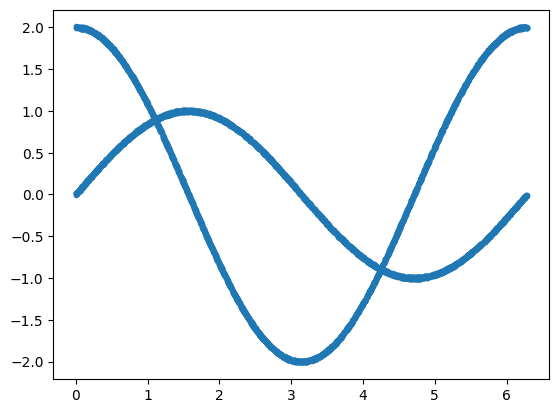

In [135]:
train_data_length = 1024*6

train_data = torch.zeros((train_data_length, 2))

#train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length)

#train_data[:, 1] = torch.sin(train_data[:, 0])

train_data[:train_data_length//2, 0] = 2 * math.pi * torch.rand(train_data_length//2)

train_data[train_data_length//2:, 0] = 2 * math.pi * torch.rand(train_data_length//2)

train_data[:train_data_length//2, 1] = torch.sin(train_data[:train_data_length//2, 0]) + 0.01 * torch.sin(train_data[train_data_length//2:, 0])

train_data[train_data_length//2:, 1] = 2 * torch.cos(train_data[train_data_length//2:, 0]) + 0.01 * torch.sin(train_data[:train_data_length//2, 0])



train_labels = torch.zeros(train_data_length)

train_set = [

    (train_data[i], train_labels[i]) for i in range(train_data_length)

]
plt.plot(train_data[:, 0], train_data[:, 1], ".")

In [136]:
def plot_samples(generated_samples):
    plt.figure()
    plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")
    plt.show()
    plt.close()

In [137]:
class Network(nn.Module):
    def __init__(self, type, input_size, hidden_sizes, output_size, dropout=False, dropout_rate=0.3):
        super().__init__()
        
        layers = []
        previous_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(previous_size, hidden_size))
            layers.append(nn.ReLU())
            if dropout:
                layers.append(nn.Dropout(dropout_rate))
            previous_size = hidden_size

        layers.append(nn.Linear(previous_size, output_size))
        
        if type == 'discriminator':
            layers.append(nn.Sigmoid())
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        output = self.model(x)
        return output

In [162]:
batch_size = 64*96
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

lr = 0.0004

num_epochs = 12000

loss_function = nn.BCELoss()

n = 3

discriminator = Network('discriminator', input_size=2, hidden_sizes=[n * i for i in [256, 128, 64]], output_size=1, dropout=True, dropout_rate=0.2).to(device)
generator = Network('generator', input_size=2, hidden_sizes=[n * i for i in [16, 32, 64]], output_size=2, dropout=False).to(device)

#discriminator = Discriminator().to(device)
#generator = Generator().to(device)

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

Epoch: 0 Loss D.: 0.6808507442474365
Epoch: 0 Loss G.: 0.6652267575263977


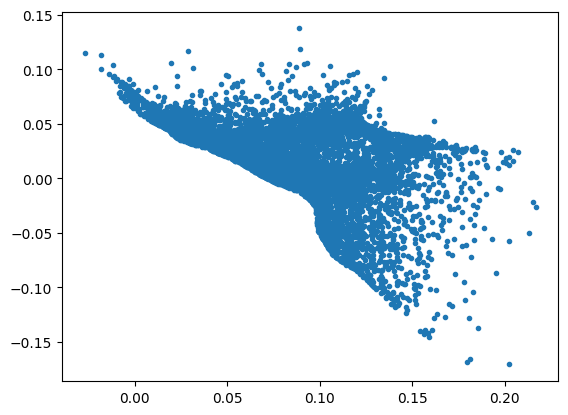

Epoch: 2000 Loss D.: 0.6300018429756165
Epoch: 2000 Loss G.: 0.8258398771286011


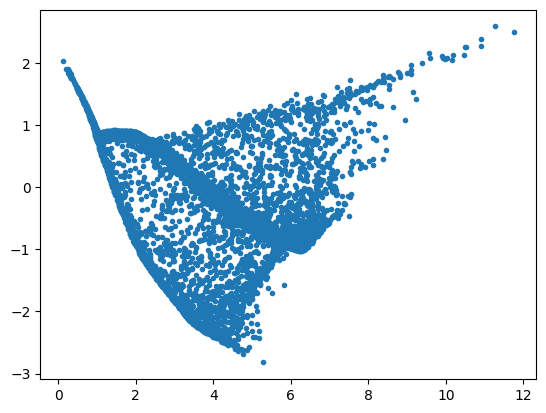

Epoch: 4000 Loss D.: 0.6522362232208252
Epoch: 4000 Loss G.: 0.7626883387565613


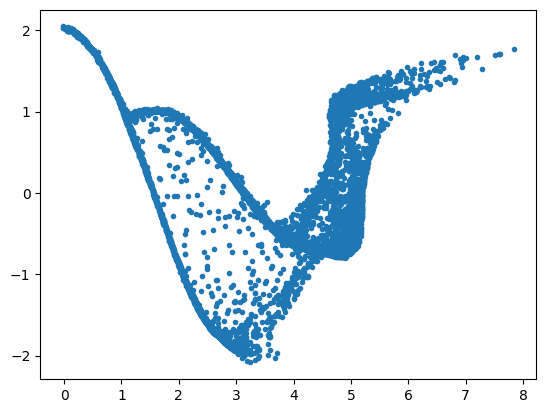

Epoch: 6000 Loss D.: 0.6516129970550537
Epoch: 6000 Loss G.: 0.8034157752990723


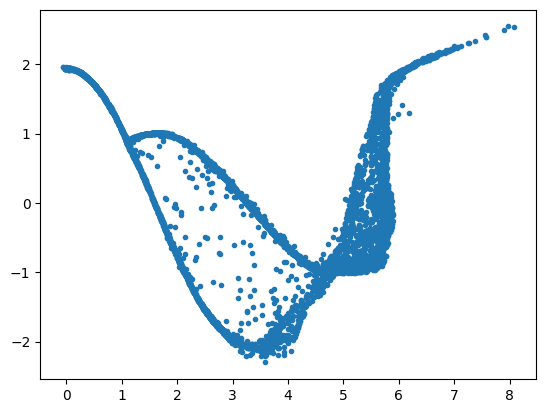

Epoch: 8000 Loss D.: 0.6503959894180298
Epoch: 8000 Loss G.: 0.7655086517333984


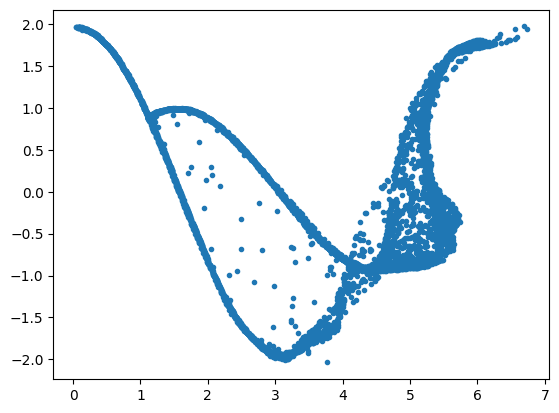

Epoch: 10000 Loss D.: 0.6625611186027527
Epoch: 10000 Loss G.: 0.7485532760620117


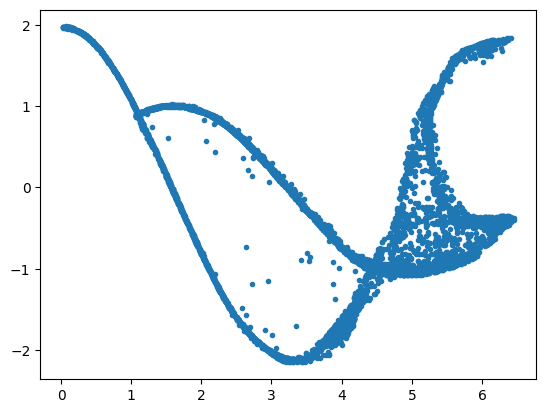

In [163]:
for epoch in range(num_epochs):

    for n, (real_samples, _) in enumerate(train_loader):

        # Data for training the discriminator

        real_samples = real_samples.to(device)
        
        real_samples_labels = torch.ones((batch_size, 1)).to(device)

        latent_space_samples = torch.randn((batch_size, 2)).to(device)

        generated_samples = generator(latent_space_samples)

        generated_samples_labels = torch.zeros((batch_size, 1)).to(device)

        all_samples = torch.cat((real_samples, generated_samples))

        all_samples_labels = torch.cat(

            (real_samples_labels, generated_samples_labels)

        )


        # Training the discriminator

        discriminator.zero_grad()

        output_discriminator = discriminator(all_samples)

        loss_discriminator = loss_function(

            output_discriminator, all_samples_labels
        )

        loss_discriminator.backward()

        optimizer_discriminator.step()


        # Data for training the generator

        latent_space_samples = torch.randn((batch_size, 2)).to(device)


        # Training the generator

        generator.zero_grad()

        generated_samples = generator(latent_space_samples)

        output_discriminator_generated = discriminator(generated_samples)

        loss_generator = loss_function(

            output_discriminator_generated, real_samples_labels

        )

        loss_generator.backward()

        optimizer_generator.step()


        # Show loss

        if epoch % 2000 == 0 and n == 0:

            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")

            print(f"Epoch: {epoch} Loss G.: {loss_generator}")
            
            latent_space_samples = torch.randn(train_data_length, 2).to(device)
            generated_samples = generator(latent_space_samples)
            generated_samples = generated_samples.cpu().detach()
            plot_samples(generated_samples)

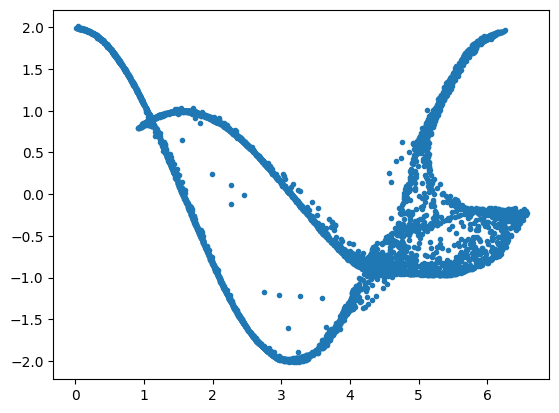

In [164]:
latent_space_samples = torch.randn(train_data_length, 2).to(device)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.cpu().detach()
plot_samples(generated_samples)